In [1]:
import comet_ml
from comet_ml.query import Parameter

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from IPython.core.display import display, HTML

In [2]:
def get_epoch_info(df):
    df_train = df[~ df['train_1mae_epoch'].isnull()][['epoch', 'train_1mae_epoch']]
    df_valid = df[~ df['valid_1mae'].isnull()][['epoch', 'valid_1mae']]
    return df_train.merge(df_valid, on='epoch')

In [3]:
comet_api = comet_ml.api.API()

In [4]:
exps = comet_api.query("transformer", "compare-loss", Parameter('limit') == 1.0)

In [5]:
csv_dir = Path('logs/csv')

In [6]:
dfs = {}
for exp in exps:
    i = exp.id
    dfs[i] = pd.read_csv(csv_dir / i / "version_0" / "metrics.csv")

In [7]:
dfs = {k: get_epoch_info(df) for k, df in dfs.items()}

In [8]:
dfs_list = list(dfs.values())

In [9]:
wrong_ids = []
for k, df in dfs.items():
    if k == '3b9590b112734f4199faee4e671656d4': # still running
        continue
    ac_max = list(np.maximum.accumulate(df['valid_1mae']))
    if (ac_max[-11] != ac_max[-1]) or ((len(ac_max) > 11) and (ac_max[-12] > ac_max[-11])):
        wrong_ids.append(k)

In [10]:
n_wrong = len(wrong_ids)
n_total = len(dfs_list)
print(f"{n_wrong} out of {n_total} are not fulfilling the early stopping criteria!")

2 out of 16 are not fulfilling the early stopping criteria!


In [11]:
urls = [f"https://www.comet.ml/transformer/compare-loss/{i}?experiment-tab=params" for i in wrong_ids]
for url in urls:
    display(HTML(f'<a href="{url}">{url}</a>'))

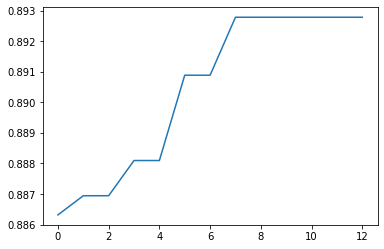

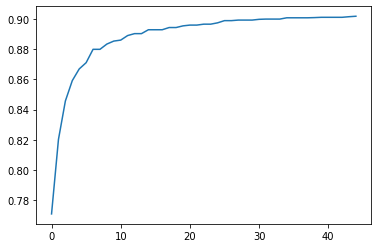

In [12]:
for k in wrong_ids:
    df = dfs[k]
    plt.plot(np.maximum.accumulate(df['valid_1mae']))
    plt.show()